# Задание

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

Проверьте:

1. Был ли эксперимент успешен в целом?
2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей?

# Исходные данные

Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

    users_*.csv – информация о пользователях:

***uid*** – идентификатор пользователя

***age*** – возраст

***attraction_coeff*** – коэффициент привлекательности

***coins*** – число монеток (внутренняя валюта)

***country*** – страна  

***visit_days*** – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)

***gender*** – пол

***age_filter_start***  – фильтр поиска, мин. значение 

***age_filter_end***  – фильтр поиска, макс. значение 

***views_count*** – число полученных оценок 

***was_premium*** – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)

***is_premium*** –  является ли премиум

***total_revenue*** – нормированная выручка
 
     transactions_*.csv – информация о платежах пользователей:

***uid*** – идентификатор пользователя

***country*** – страна

***joined_at*** – дата и время регистрации

***paid_at*** – дата и время покупки

***revenue*** – нормированная выручка

***payment_id*** – идентификатор платежа

***from_page*** – откуда пользователь перешел на страницу оплаты

***product_type*** – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)

# Импортируем необходимые библиотеки:

In [323]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from  scipy.stats import chi2_contingency
from  scipy.stats import boxcox
from  scipy.stats import levene
from  scipy.stats import kruskal
from  scipy.stats import shapiro
from  pingouin    import welch_anova

import scikit_posthocs as sp

from IPython.display import Image

# Импортиурем исходные датафреймы теста:

    1. Датафрейм всех пользователей в тесте:


In [26]:
users_test = pd.read_csv(r"C:\Users\-\Documents\Финальный проект\Проект_3_users_test.csv", sep=';')

print(f'\nРазмер датафрейма: {users_test.shape}')
users_test.head()


Размер датафрейма: (4308, 13)


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


    2. Датафрейм платящих пользователей в тесте:


In [30]:
transactions_test = pd.read_csv(r"C:\Users\-\Documents\Финальный проект\Проект_3_transactions_test.csv", sep=';')

print(f'\nРазмер датафрейма: {transactions_test.shape}')
transactions_test.head()


Размер датафрейма: (273, 8)


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


# Импортируем исходные датафреймы контроля:

    1. Датафреймы всех пользователей в контроле:

In [31]:
users_control_1 = pd.read_csv(r"C:\Users\-\Documents\Финальный проект\Проект_3_users_control_1.csv", sep=';')

users_control_2 = pd.read_csv(r"C:\Users\-\Documents\Финальный проект\Проект_3_users_control_2.csv", sep=';')

In [446]:
# Посмотрим как выглядит датафрейм 1:
users_control_1.head(2)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_rate,age_cat,is_buyer
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0,developed_country,young,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0,developed_country,middle,0


In [445]:
# Посмотрим как выглядит датафрейм 2:
users_control_2.head(2)

,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue,country_rate,age_cat,is_buyer
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0,developed_country,older,0
1,892317273,37,0,NaN,Israel,NaN,1,34,40,0,NaN,NaN,0,developed_country,older,0


    2. Датафреймы платящих пользователей в контроле:

In [32]:
transactions_control_1 = pd.read_csv(r"C:\Users\-\Documents\Финальный проект\Проект_3_transactions_control_1.csv", sep=';')

transactions_control_2 = pd.read_csv(r"C:\Users\-\Documents\Финальный проект\Проект_3_transactions_control_2.csv", sep=';')

In [442]:
# Посмотрим как выглядит датафрейм 1:
transactions_control_1.head(2)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,country_rate
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium,developed_country
1,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins,developed_country


In [444]:
# Посмотрим как выглядит датафрейм 2:
transactions_control_2.head(2)

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,country_rate
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins,developed_country
1,892128138,Argentina,2017-10-20 14:49:00,2017-11-15 02:15:00,1261,19,menu,coins,developed_country


# Задание 1. Был ли эксперимент успешен в целом?

     ТЕРМИНОЛОГИЯ:

1.  **CR1** - конверсия в первую покупку.
2.  **ARPPU** (Average Revenue per Paying User) - средний доход с платящего пользователя.
3.  **Purchase frequency** - среднее кол-во повторных покупок, совершаемых клиентом.
4.  **avg_bill** - средний чек покупки.

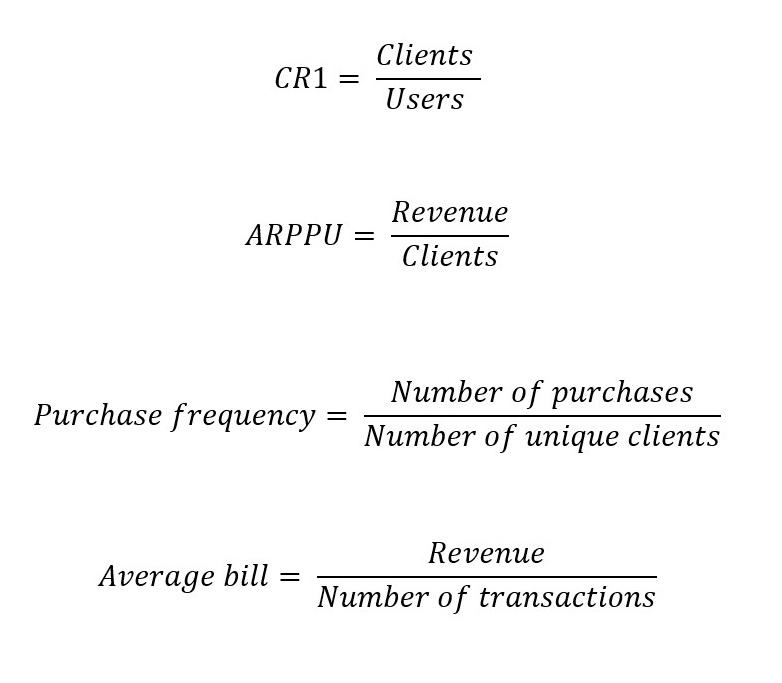

In [156]:
Image(r"C:\Users\-\Pictures\formulaes.jpg", width=500)

    1. Посчитаем основные метрики для теста и контроля:

In [164]:
# Узнаем конверсию в первую покупку у пользователей в тесте:
CR1_test = transactions_test.uid.nunique() / users_test.uid.nunique()

# Узнаем ARPPU теста:
ARPPU_test = transactions_test.groupby('uid').agg({'revenue':'sum'}).revenue.mean()

# Узнаем среднее число повторных покупок теста:
purchase_frequency_test = round(transactions_test.revenue.count() / transactions_test.uid.nunique(), 2)

# Узнаем средний чек теста:
avg_bill_test = int(transactions_test.groupby('paid_at', as_index=False).agg({'revenue':'sum'}).revenue.mean())

In [166]:
# Узнаем конверсию в первую покупку у пользователей в контроле:
CR1_control_1 = transactions_control_1.uid.nunique() / users_control_1.uid.nunique()
CR1_control_2 = transactions_control_2.uid.nunique() / users_control_2.uid.nunique()

# Узнаем ARPPU контроля:
ARPPU_control_1 = int(transactions_control_1.groupby('paid_at', as_index=False).agg({'revenue':'sum'}).revenue.mean())
ARPPU_control_2 = int(transactions_control_2.groupby('paid_at', as_index=False).agg({'revenue':'sum'}).revenue.mean())


# Узнаем среднее число повторных покупок контроля:
purchase_frequency_control_1 = round(transactions_control_1.revenue.count() / transactions_control_1.uid.nunique(), 2)
purchase_frequency_control_2 = round(transactions_control_2.revenue.count() / transactions_control_2.uid.nunique(), 2)

# Узнаем средний чек контроля:
avg_bill_control_1 = int(transactions_control_1.revenue.mean())
avg_bill_control_2 = int(transactions_control_2.revenue.mean())

In [167]:
# Результаты в виде таблицы:

pd.DataFrame({'CR1':[round(CR1_test, 2), round(CR1_control_1, 2), round(CR1_control_2, 2)],
              'ARPPU':[int(ARPPU_test), int(ARPPU_control_1), int(ARPPU_control_2)],
              'purchase_frequency':[purchase_frequency_test, purchase_frequency_control_1, purchase_frequency_control_2],
              'avg_bill':[avg_bill_test, avg_bill_control_1, avg_bill_control_2]}, 
              index=['test', 'control_1', 'control_2'])

,CR1,ARPPU,purchase_frequency,avg_bill
test,0.03,16060,1.87,9088
control_1,0.04,7797,1.95,6929
control_2,0.04,6215,1.75,5854


***Делаем вывод в целом по эксперименту, что конверсия в первую покупку и повторные покупки существенно не изменились, а средний доход с платящего пользователя  и средний чек выросли. Поэтому можно сказать, что в целом эксперимент был успешен, т.к. выручка с одного количества пользователей при новой стратегии оказалась бы выше.***

---

# Задание 2. Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.


    1. Добавим столбцы - рейтинг развитости страны:

Внешние данные взяты с: https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D1%82%D1%80%D0%B0%D0%BD_%D0%BF%D0%BE_%D0%B8%D0%BD%D0%B4%D0%B5%D0%BA%D1%81%D1%83_%D1%87%D0%B5%D0%BB%D0%BE%D0%B2%D0%B5%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B3%D0%BE_%D1%80%D0%B0%D0%B7%D0%B2%D0%B8%D1%82%D0%B8%D1%8F

In [447]:
# Импортируем внешний файл - индекс развития страны:

hdi_vs_country = pd.read_csv(r"C:\Users\-\Documents\Финальный проект\HDI by country.csv")

hdi_vs_country.country = hdi_vs_country.country.apply(lambda x: x.replace('South Korea','Korea, Republic of')\
                                                                 .replace('United States', 'United States of America')\
                                                                 .replace('United Kingdom', 'United Kingdom (Great Britain)')\
                                                                 .replace('Russia', 'Russian Federation')\
                                                                 .replace('Iran','Islamic Republic of Iran'))

# Делим страны на развитые, развивающиеся и неразвитые:
hdi_vs_country['country_rate'] = pd.cut(hdi_vs_country.hdi, 
                                        3, 
                                        labels=['least_developed_countries', 'developing_country', 'developed_country'])

# Оставляем только нужные столбцы:
hdi_vs_country = hdi_vs_country[['country', 'country_rate']]

hdi_vs_country.sample(4)

,country,country_rate
149,Solomon Islands,least_developed_countries
24,Spain,developed_country
122,Tajikistan,developing_country
164,Sudan,least_developed_countries


In [448]:
# Добавляем в каждый датафрейм - столбец развитости страны пользователя:

users_test = users_test.merge(hdi_vs_country, on='country')
transactions_test = transactions_test.merge(hdi_vs_country, on='country')

users_control_1 = users_control_1.merge(hdi_vs_country, on='country')
users_control_2 = users_control_2.merge(hdi_vs_country, on='country')

transactions_control_1 = transactions_control_1.merge(hdi_vs_country, on='country')
transactions_control_2 = transactions_control_2 .merge(hdi_vs_country, on='country')

    2. Добавим столбец - категория возраста пользователя:

In [449]:
# Делим возраста юзеров на 3 категории - по квантилям возрастов тестовой группы:

q0   = users_test['age'].quantile(0)
q33  = users_test['age'].quantile(0.33)
q66  = users_test['age'].quantile(0.66)
q100 = users_test['age'].quantile(1)

age_quantiles = [q0, q33, q66, q100]

age_labels = ['young', 'middle', 'older']

In [450]:
# Добавляем стобцы - категория возраста пользователя:
users_test['age_cat']      = pd.cut(users_test['age'], age_quantiles, labels = age_labels)
users_control_1['age_cat'] = pd.cut(users_control_1['age'], age_quantiles, labels = age_labels)
users_control_2['age_cat'] = pd.cut(users_control_2['age'], age_quantiles, labels = age_labels)

---

    3. Считаем конверсию в первую покупку у разных групп пользователей:

In [40]:
# Добавим столбец - совершил ли пользователь покупки:

users_test['is_buyer']      = users_test.uid.apply(lambda x: 1 if x in transactions_test.uid.unique() else 0)
users_control_1['is_buyer'] = users_control_1.uid.apply(lambda x: 1 if x in transactions_control_1.uid.unique() else 0)
users_control_2['is_buyer'] = users_control_2.uid.apply(lambda x: 1 if x in transactions_control_2.uid.unique() else 0)

In [41]:
# Считаем конверсию в первую покупку:

CR1_test = users_test.groupby(['gender', 'country_rate', 'age_cat'])\
                     .agg({'is_buyer':lambda x: round(x.mean(), 3),'uid':'count'})\
                     .reset_index()\
                     .dropna().rename(columns={'is_buyer':'CR1_test', 'uid':'test_sample'})

CR1_control_1 = users_control_1.groupby(['gender', 'country_rate', 'age_cat'])\
                     .agg({'is_buyer':lambda x: round(x.mean(), 3),'uid':'count'})\
                     .reset_index()\
                     .dropna().rename(columns={'is_buyer':'CR1_control_1', 'uid':'control_1_sample'})

CR1_control_2 = users_control_2.groupby(['gender', 'country_rate', 'age_cat'])\
                     .agg({'is_buyer':lambda x: round(x.mean(), 3),'uid':'count'})\
                     .reset_index()\
                     .dropna().rename(columns={'is_buyer':'CR1_control_2', 'uid':'control_2_sample'})

# Объединяем в один датафрейм:
CR_1_result = CR1_test.merge(CR1_control_1, on=['gender', 'country_rate', 'age_cat'])\
                       .merge(CR1_control_2, on=['gender', 'country_rate', 'age_cat'])


# Исключаем группы пользователей со слишком маленькими образовавшимися выборками (т.к. они нерепрезентативны и исказят выводы):
CR_1_result = CR_1_result.query('test_sample>10 and control_1_sample>10  and control_2_sample>10')

CR_1_result = CR_1_result[['gender', 'country_rate', 'age_cat', 'CR1_test', 'CR1_control_1', 'CR1_control_2']]

CR_1_result

,gender,country_rate,age_cat,CR1_test,CR1_control_1,CR1_control_2
0,0,developed_country,young,0.014,0.000,0.012
1,0,developed_country,middle,0.012,0.048,0.043
2,0,developed_country,older,0.000,0.024,0.081
5,1,developing_country,middle,0.000,0.000,0.000
7,1,developed_country,young,0.030,0.052,0.047
8,1,developed_country,middle,0.039,0.047,0.044
9,1,developed_country,older,0.039,0.039,0.042


    4. Определяем стат. значимость отличия конверсии у разных эксперим. групп (используя критерий хи-квадрат):

In [42]:
# Сопоставим каждой группе пользователей - количество совершавших и несовершавших покупки человек в разных эксп. группах:

counts_test = users_test.groupby(['gender', 'country_rate', 'age_cat'])\
                     .agg({'is_buyer':lambda x: [x.to_list().count(1), x.to_list().count(0)]})\
                     .reset_index()\
                     .dropna().rename(columns={'is_buyer':'counts_test'})

counts_control_1 = users_control_1.groupby(['gender', 'country_rate', 'age_cat'])\
                     .agg({'is_buyer':lambda x: [x.to_list().count(1), x.to_list().count(0)]})\
                     .reset_index()\
                     .dropna().rename(columns={'is_buyer':'counts_control_1'})

counts_control_2 = users_control_2.groupby(['gender', 'country_rate', 'age_cat'])\
                     .agg({'is_buyer':lambda x: [x.to_list().count(1), x.to_list().count(0)]})\
                     .reset_index()\
                     .dropna().rename(columns={'is_buyer':'counts_control_2'})

# Мёрджим это к датафрейму конверсий:
CR_1_result = CR_1_result.merge(counts_test, on=['gender', 'country_rate', 'age_cat'])\
                         .merge(counts_control_1, on=['gender', 'country_rate', 'age_cat'])\
                         .merge(counts_control_2, on=['gender', 'country_rate', 'age_cat'])

# Получаем для каждого сегмента юзеров и эксп. группы - список: [число покупателей, число не покупателей] из юзеров:
CR_1_result

,gender,country_rate,age_cat,CR1_test,CR1_control_1,CR1_control_2,counts_test,counts_control_1,counts_control_2
0,0,developed_country,young,0.014,0.000,0.012,"[1, 71]","[0, 67]","[1, 80]"
1,0,developed_country,middle,0.012,0.048,0.043,"[1, 82]","[3, 60]","[3, 66]"
2,0,developed_country,older,0.000,0.024,0.081,"[0, 36]","[1, 41]","[3, 34]"
3,1,developing_country,middle,0.000,0.000,0.000,"[0, 16]","[0, 11]","[0, 15]"
4,1,developed_country,young,0.030,0.052,0.047,"[40, 1286]","[71, 1282]","[62, 1244]"
5,1,developed_country,middle,0.039,0.047,0.044,"[53, 1310]","[62, 1266]","[59, 1294]"
6,1,developed_country,older,0.039,0.039,0.042,"[51, 1245]","[53, 1316]","[55, 1240]"


In [43]:
# Использую хи-квадрат определим отличиются ли стат. значимо конверсии контролей между собой (аналог А-А теста):

control_pvalue = []

for i in range(len(CR_1_result)):
    try:
        control_1_array = CR_1_result.counts_control_1.to_list()[i]
        control_2_array = CR_1_result.counts_control_2.to_list()[i]
    
        kf_data = [control_1_array, control_2_array]
    
        g, p_value, dof, expctd = chi2_contingency(kf_data) 
    
        control_pvalue.append(round(p_value,2))   
        
    except:
        control_pvalue.append(np.nan) 
        
# Добавим столбец - отсутствие стат. значимого различия в конверсии между контролями:
CR_1_result['controls_pvalue'] = control_pvalue

In [44]:
# Используем хи-квадрат определим отличиются ли стат. значимо конверсии контролей от теста:

control_vs_test_pvalue = []

for i in range(len(CR_1_result)):
    try:
        control_1_array = CR_1_result.counts_control_1.to_list()[i]
        control_2_array = CR_1_result.counts_control_2.to_list()[i]
        test_array = CR_1_result.counts_test.to_list()[i]
    
        kf_data = [control_1_array, control_2_array, test_array]
    
        g, p_value, dof, expctd = chi2_contingency(kf_data) 
    
        control_vs_test_pvalue.append(round(p_value,2))   
        
    except:
        control_vs_test_pvalue.append(np.nan) 
        
# Добавим столбец - отсутствие стат. значимого различия в конверсии между тестом и контролями:
CR_1_result['control_vs_test_pvalue'] = control_vs_test_pvalue

In [451]:
# Смотрим результат:

CR_1_result = CR_1_result[['gender', 'country_rate', 'age_cat', 'CR1_test', 'CR1_control_1',
                           'CR1_control_2', 'controls_pvalue', 'control_vs_test_pvalue']]

CR_1_result

,gender,country_rate,age_cat,CR1_test,CR1_control_1,CR1_control_2,controls_pvalue,control_vs_test_pvalue
0,0,developed_country,young,0.014,0.000,0.012,1.00,0.64
1,0,developed_country,middle,0.012,0.048,0.043,1.00,0.40
2,0,developed_country,older,0.000,0.024,0.081,0.52,0.15
3,1,developing_country,middle,0.000,0.000,0.000,NaN,NaN
4,1,developed_country,young,0.030,0.052,0.047,0.62,0.01
5,1,developed_country,middle,0.039,0.047,0.044,0.77,0.60
6,1,developed_country,older,0.039,0.039,0.042,0.69,0.87


***Делаем вывод, что у всех групп пользователей конверсии между двумя контролями стат. значимо не отличаются (Это означает, что А-А тест, если бы он был, был бы пройден).***

***У одной из групп юзеров математически невозможно посчитать хи-квадрат, но во всех выборках конверсия была нулевой, что позволяет полагать, что среди них также нет стат. значимого отличия.***

***Ключевым выводом является - для всех групп пользователей конверсии стат. значимо не отличаются между контролями и тестом. Поэтому можно заявлять, что на конверсию в первую покупку, нововведение не повлияло.***

---

    5. Считаем ARPPU (average revenue per paying user) у разных групп пользователей:

In [46]:
# Сопоставим каждой группе пользователей - списки значений выручек с ее пользователей:

ARPPU_test = transactions_test.groupby(['uid'], as_index=False)\
                              .agg({'revenue':'sum'})\
                              .merge(users_test[['uid', 'gender', 'age_cat', 'country_rate']], on='uid')\
                              .groupby(['gender', 'country_rate', 'age_cat'])\
                              .agg({'revenue':lambda x: x.to_list(),'uid':'count'})\
                              .rename(columns={'revenue':'revenues_test', 'uid':'test_sample'})\
                              .reset_index()

ARPPU_control_1 = transactions_control_1.groupby(['uid'], as_index=False)\
                              .agg({'revenue':'sum'})\
                              .merge(users_control_1[['uid', 'gender', 'age_cat', 'country_rate']], on='uid')\
                              .groupby(['gender', 'country_rate', 'age_cat'])\
                              .agg({'revenue':lambda x: x.to_list(),'uid':'count'})\
                              .rename(columns={'revenue':'revenues_control_1', 'uid':'control_1_sample'})\
                              .reset_index()

ARPPU_control_2 = transactions_control_2.groupby(['uid'], as_index=False)\
                              .agg({'revenue':'sum'})\
                              .merge(users_control_2[['uid', 'gender', 'age_cat', 'country_rate']], on='uid')\
                              .groupby(['gender', 'country_rate', 'age_cat'])\
                              .agg({'revenue':lambda x: x.to_list(),'uid':'count'})\
                              .rename(columns={'revenue':'revenues_control_2', 'uid':'control_2_sample'})\
                              .reset_index()

# Объединяем в один датафрейм:
ARPPU_result = ARPPU_test.merge(ARPPU_control_1, on=['gender', 'country_rate', 'age_cat'])\
                         .merge(ARPPU_control_2, on=['gender', 'country_rate', 'age_cat'])

# Исключаем группы пользователей со слишком маленькими образовавшимися выборками (т.к. они нерепрезентативны и исказят выводы):
ARPPU_result = ARPPU_result.query('test_sample>10 and control_1_sample>10  and control_2_sample>10')


ARPPU_result = ARPPU_result[['gender', 'country_rate', 'age_cat', 'revenues_test', 'revenues_control_1', 'revenues_control_2']]

ARPPU_result

,gender,country_rate,age_cat,revenues_test,revenues_control_1,revenues_control_2
15,1,developed_country,young,"[9100, 12831, 12597, 25636, 12727, 11778, 2158...","[9945.0, 6292.0, 10075.0, 4680.0, 2327.0, 1258...","[6292, 17290, 1794, 2613, 6292, 9438, 5278, 89..."
16,1,developed_country,middle,"[12597, 28080, 897, 12727, 9087, 18304, 19370,...","[12727.0, 4602.0, 3588.0, 13273.0, 6292.0, 252...","[10296, 7384, 6084, 3900, 18902, 2964, 6292, 6..."
17,1,developed_country,older,"[129870, 12597, 12727, 12727, 12727, 16406, 14...","[11869.0, 962.0, 10517.0, 9087.0, 6292.0, 8814...","[2327, 15132, 10413, 6500, 9087, 9919, 12727, ..."


In [47]:
# Добавляем столбцы - ARPPU каждой группы пользователей:

ARPPU_result['ARPPU_test'] = ARPPU_result['revenues_test'].apply(np.mean)
ARPPU_result['ARPPU_control_1'] = ARPPU_result['revenues_control_1'].apply(np.mean)
ARPPU_result['ARPPU_control_2'] = ARPPU_result['revenues_control_2'].apply(np.mean)

ARPPU_result[['gender', 'country_rate', 'age_cat', 'ARPPU_test', 'ARPPU_control_1', 'ARPPU_control_2']]

,gender,country_rate,age_cat,ARPPU_test,ARPPU_control_1,ARPPU_control_2
15,1,developed_country,young,18526.625000,18682.281690,7848.016129
16,1,developed_country,middle,14466.547170,9757.548387,12632.033898
17,1,developed_country,older,15882.941176,11685.528302,11116.890909


In [48]:
# Ни одна из образовавшихся выборок выручек с пользователей не нормальна::

ARPPU_result[['revenues_control_1', 'revenues_control_2', 'revenues_test']].applymap(lambda x: shapiro(x).pvalue)

,revenues_control_1,revenues_control_2,revenues_test
15,1.322532e-17,1.067703e-02,3.645957e-10
16,1.081233e-03,1.644150e-11,8.134475e-09
17,1.199390e-08,2.528270e-03,2.376603e-11


In [133]:
# Для каждой группы пользователей узнаем гомогенны ли ее выборки выручек: тест, контроль 1 и контроль 2:

levene_p_values = []

for i in range(len(ARPPU_result)):
    sample_test = ARPPU_result.revenues_test.to_list()[i]
    sample_control_1 = ARPPU_result.revenues_control_1.to_list()[i]
    sample_control_2 = ARPPU_result.revenues_control_2.to_list()[i]
    
    levene_p_values.append(levene(sample_test, sample_control_1, sample_control_2).pvalue)

ARPPU_result['levene_test_pvalue'] = levene_p_values


# Видим, что у всех групп пользователей выполняются требования к гомогенности их экспериментальных выборок (pvalue>0.05):
ARPPU_result[['gender', 'country_rate', 'age_cat', 'levene_test_pvalue']]

,gender,country_rate,age_cat,levene_test_pvalue
15,1,developed_country,young,0.304775
16,1,developed_country,middle,0.243045
17,1,developed_country,older,0.118899


In [50]:
# Для каждой группы пользователей применим тест Краскалла-Уоллиса (непараметрический аналог ANOVA), 
# чтобы узнать есть ли хоть одна стат. значимо отличающаяся выборка среди экспериментальных:

kruskal_p_values = []

for i in range(len(ARPPU_result)):
    sample_test = ARPPU_result.revenues_test.to_list()[i]
    sample_control_1 = ARPPU_result.revenues_control_1.to_list()[i]
    sample_control_2 = ARPPU_result.revenues_control_2.to_list()[i]
    
    kruskal_p_values.append(kruskal(sample_test, sample_control_1, sample_control_2).pvalue)

ARPPU_result['kruskal_test_pvalue'] = kruskal_p_values

In [51]:
# Видим, что хотя бы 1 стат. значимо отличный ARPPU есть среди экспериментальных
# выборок только 1 группы юзеров (gender=1, country_rate='developed_country', age_cat='young'):

ARPPU_result[['gender', 'country_rate', 'age_cat', 'kruskal_test_pvalue']]

,gender,country_rate,age_cat,kruskal_test_pvalue
15,1,developed_country,young,0.000092
16,1,developed_country,middle,0.116048
17,1,developed_country,older,0.469079


In [52]:
# Проведем попарный тест Данна (непарам. тест), чтобы узнать между какими именно эксп. группами есть стат. значимое различие:

sample_test = ARPPU_result.revenues_test.to_list()[0]
sample_control_1 = ARPPU_result.revenues_control_1.to_list()[0]
sample_control_2 = ARPPU_result.revenues_control_2.to_list()[0]
samples = [sample_test, sample_control_1, sample_control_2]

dunn_table = sp.posthoc_dunn(samples)
dunn_table.index = ['test', 'control_1', 'control_2']
dunn_table.columns = ['test', 'control_1', 'control_2']
dunn_table

,test,control_1,control_2
test,1.000000,0.004259,0.000017
control_1,0.004259,1.000000,0.076356
control_2,0.000017,0.076356,1.000000


In [53]:
"""
Видим, что тест имеет стат. значимое отличие с обоими контролями, а контроли стат. значимы не отличаются между собой.
Однако, средние контролей совершенно разные (скорее всего из-за выбросов). 
В результате этого средний ARPPU контроля №1 больше, чем у теста; а у контроля №2 - меньше. 
Вследвствие этого, основываясь на средних, мы не можем сказать улучшился ли ARPPU у теста или нет. 
Тогда применим медианы (менее чувствительны к выбросам):
"""

# Теперь становится понятно, что в данной группе юзеров ARPPU теста стат. значимо выше, чем в контролях:

print(f'\nМедианный ARPPU теста: {int(np.median(sample_test))}')
print(f'Медианный ARPPU контроля 1: {int(np.median(sample_control_1))}')
print(f'Медианный ARPPU контроля 2: {int(np.median(sample_control_2))}')


Медианный ARPPU теста: 12727
Медианный ARPPU контроля 1: 9087
Медианный ARPPU контроля 2: 6376


***Делаем вывод, что у группы пользователей - gender=1, country_rate='developed_country', age_cat='young' величина ARPPU стала стат. значимо выше после нововведения. У остальных же групп пользователей стат. значимых изменений ARPPU после нововведения не произошло.***

---

    6. Считаем Purchase Frequency (среднее кол-во повторных покупок) у разных групп пользователей:

In [126]:
# Каждой группе юзеров сопоставим список значений повторных покупок для каждого человека:

PF_test = transactions_test.groupby('uid', as_index=False)\
                           .agg({'revenue':'count'})\
                           .merge(users_test[['gender', 'country_rate', 'age_cat','uid']], on='uid')\
                           .groupby(['gender', 'country_rate','age_cat'])\
                           .agg({'revenue':lambda x: x.to_list(), 'uid':'count'})\
                           .rename(columns={'revenue':'buys_count_test', 'uid':'test_sample'})\
                           .reset_index()\
                           .dropna()

PF_control_1 = transactions_control_1.groupby('uid', as_index=False)\
                           .agg({'revenue':'count'})\
                           .merge(users_control_1[['gender', 'country_rate', 'age_cat','uid']], on='uid')\
                           .groupby(['gender', 'country_rate','age_cat'])\
                           .agg({'revenue':lambda x: x.to_list(), 'uid':'count'})\
                           .rename(columns={'revenue':'buys_count_control_1', 'uid':'control_1_sample'})\
                           .reset_index()\
                           .dropna()

PF_control_2 = transactions_control_2.groupby('uid', as_index=False)\
                           .agg({'revenue':'count'})\
                           .merge(users_control_2[['gender', 'country_rate', 'age_cat','uid']], on='uid')\
                           .groupby(['gender', 'country_rate','age_cat'])\
                           .agg({'revenue':lambda x: x.to_list(), 'uid':'count'})\
                           .rename(columns={'revenue':'buys_count_control_2', 'uid':'control_2_sample'})\
                           .reset_index()\
                           .dropna()

# Объединяем в один датафрейм:
PF_result = PF_test.merge(PF_control_1, on=['gender', 'country_rate', 'age_cat'])\
                         .merge(PF_control_2, on=['gender', 'country_rate', 'age_cat'])

# Исключаем группы пользователей со слишком маленькими образовавшимися выборками (т.к. они нерепрезентативны и исказят выводы):
PF_result = PF_result.query('test_sample>10 and control_1_sample>10  and control_2_sample>10')

PF_result = PF_result[['gender', 'country_rate', 'age_cat', 'buys_count_test', 'buys_count_control_1', 'buys_count_control_2']]

PF_result

,gender,country_rate,age_cat,buys_count_test,buys_count_control_1,buys_count_control_2
1,1,developed_country,young,"[1, 1, 1, 2, 1, 2, 3, 1, 1, 3, 1, 5, 2, 1, 1, ...","[3, 1, 2, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 3, 2, 3, 1, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, ..."
2,1,developed_country,middle,"[1, 6, 1, 1, 1, 2, 6, 1, 3, 1, 1, 1, 4, 5, 1, ...","[1, 1, 1, 1, 1, 5, 1, 4, 3, 2, 2, 5, 3, 1, 3, ...","[2, 2, 2, 1, 3, 2, 1, 1, 1, 1, 1, 2, 1, 1, 2, ..."
3,1,developed_country,older,"[3, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 2, 1, 1, 1, 3, 1, 1, 2, 1, 3, 1, 3, 3, 2, ...","[1, 8, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, ..."


In [127]:
# Добавляем столбцы - PF (purchase frequency) каждой группы пользователей:

PF_result['PF_test']      = PF_result['buys_count_test'].apply(np.mean)
PF_result['PF_control_1'] = PF_result['buys_count_control_1'].apply(np.mean)
PF_result['PF_control_2'] = PF_result['buys_count_control_2'].apply(np.mean)

PF_result[['gender', 'country_rate', 'age_cat', 'PF_test', 'PF_control_1', 'PF_control_2']]

,gender,country_rate,age_cat,PF_test,PF_control_1,PF_control_2
1,1,developed_country,young,2.025000,2.408451,1.709677
2,1,developed_country,middle,1.962264,1.790323,1.779661
3,1,developed_country,older,1.686275,1.660377,1.890909


In [130]:
# Ни одна из образовавшихся выборок количеств покупок пользователей не нормальна::

PF_result[['buys_count_control_1', 'buys_count_control_2', 'buys_count_test']].applymap(lambda x: shapiro(x).pvalue)

,buys_count_control_1,buys_count_control_2,buys_count_test
1,3.013422e-15,1.897061e-10,1.272565e-10
2,7.018393e-11,1.355037e-09,1.354164e-10
3,1.142849e-12,1.358834e-12,1.795918e-12


In [135]:
# Для каждой группы пользователей узнаем гомогенны ли ее выборки выручек: тест, контроль 1 и контроль 2:

levene_p_values = []

for i in range(len(PF_result)):
    sample_test      = PF_result.buys_count_test.to_list()[i]
    sample_control_1 = PF_result.buys_count_control_1.to_list()[i]
    sample_control_2 = PF_result.buys_count_control_2.to_list()[i]
    
    levene_p_values.append(levene(sample_test, sample_control_1, sample_control_2).pvalue)

PF_result['levene_test_pvalue'] = levene_p_values


# Видим, что у всех групп пользователей выполняются требования к гомогенности их экспериментальных выборок (pvalue>0.05):
PF_result[['gender', 'country_rate', 'age_cat', 'levene_test_pvalue']]

,gender,country_rate,age_cat,levene_test_pvalue
1,1,developed_country,young,0.322931
2,1,developed_country,middle,0.758571
3,1,developed_country,older,0.760403


In [136]:
# Для каждой группы пользователей применим тест Краскалла-Уоллиса (непараметрический аналог ANOVA), 
# чтобы узнать есть ли хоть одна стат. значимо отличающаяся выборка среди экспериментальных:

kruskal_p_values = []

for i in range(len(PF_result)):
    sample_test = PF_result.buys_count_test.to_list()[i]
    sample_control_1 = PF_result.buys_count_control_1.to_list()[i]
    sample_control_2 = PF_result.buys_count_control_2.to_list()[i]
    
    kruskal_p_values.append(kruskal(sample_test, sample_control_1, sample_control_2).pvalue)

PF_result['kruskal_test_pvalue'] = kruskal_p_values

In [140]:
# Видим,что для каждой группы юзеров - Purchase Frequency не имеет стат. значимого отличия среди всех экспериментальных групп:
# т.к. pvalue>0.05 для каждой из групп

PF_result[['gender', 'country_rate', 'age_cat', 'kruskal_test_pvalue']]

,gender,country_rate,age_cat,kruskal_test_pvalue
1,1,developed_country,young,0.888793
2,1,developed_country,middle,0.863452
3,1,developed_country,older,0.943643


***Делаем вывод, что у всех групп пользователей нововведение не повлияло на метрику повторных покупок (Purchase Frequency).***

---

    7. Считаем Average Bill (средний чек) у разных групп пользователей:

In [186]:
# Каждой группе юзеров сопоставляем список чеков, которые они платили:

bills_test = transactions_test.groupby(['paid_at', 'uid'], as_index=False)\
                              .agg({'revenue':'sum'})\
                              .merge(users_test)\
                              .groupby(['gender', 'country_rate', 'age_cat'])\
                              .agg({'revenue':lambda x: x.to_list(), 'paid_at':'count'})\
                              .rename(columns={'revenue':'bills_test', 'paid_at':'test_sample'})\
                              .reset_index()\
                              .dropna()

bills_control_1 = transactions_control_1.groupby(['paid_at', 'uid'], as_index=False)\
                                         .agg({'revenue':'sum'})\
                                         .merge(users_control_1)\
                                         .groupby(['gender', 'country_rate', 'age_cat'])\
                                         .agg({'revenue':lambda x: x.to_list(), 'paid_at':'count'})\
                                         .rename(columns={'revenue':'bills_control_1', 'paid_at':'control_1_sample'})\
                                         .reset_index()\
                                         .dropna()

bills_control_2 = transactions_control_2.groupby(['paid_at', 'uid'], as_index=False)\
                                         .agg({'revenue':'sum'})\
                                         .merge(users_control_2)\
                                         .groupby(['gender', 'country_rate', 'age_cat'])\
                                         .agg({'revenue':lambda x: x.to_list(), 'paid_at':'count'})\
                                         .rename(columns={'revenue':'bills_control_2', 'paid_at':'control_2_sample'})\
                                         .reset_index()\
                                         .dropna()

# Объединяем в один датафрейм:
bills_result = bills_test.merge(bills_control_1, on=['gender', 'country_rate', 'age_cat'])\
                         .merge(bills_control_2, on=['gender', 'country_rate', 'age_cat'])

# Исключаем группы пользователей со слишком маленькими образовавшимися выборками (т.к. они нерепрезентативны и исказят выводы):
bills_result = bills_result.query('test_sample>10 and control_1_sample>10  and control_2_sample>10')

bills_result = bills_result[['gender', 'country_rate', 'age_cat', 'bills_test', 
                             'bills_control_1', 'bills_control_2']]

bills_result

,gender,country_rate,age_cat,bills_test,bills_control_1,bills_control_2
1,1,developed_country,young,"[6032, 9542, 6305, 6305, 6305, 6305, 12597, 82...","[1261.0, 1261.0, 3783.0, 6292.0, 3783.0, 2522....","[2015, 2015, 2015, 3913, 4732, 10088, 10088, 6..."
2,1,developed_country,middle,"[4004, 4030, 8125, 780, 4004, 4030, 3523, 3588...","[143.0, 26.0, 637.0, 9919.0, 2834.0, 2821.0, 1...","[8606, 19513, 6305, 6305, 10673, 7566, 6292, 6..."
3,1,developed_country,older,"[9451, 12727, 13247, 1599, 1898, 12818, 12597,...","[6292.0, 6448.0, 5577.0, 6292.0, 3783.0, 12610...","[12675, 4537, 1261, 13208, 6292, 6396, 10088, ..."


In [188]:
# Добавляем столбцы - avg_bill каждой группы пользователей:

bills_result['avg_bill_test']      = bills_result['bills_test'].apply(np.mean)
bills_result['avg_bill_control_1'] = bills_result['bills_control_1'].apply(np.mean)
bills_result['avg_bill_control_2'] = bills_result['bills_control_2'].apply(np.mean)

bills_result[['gender', 'country_rate', 'age_cat', 'avg_bill_test', 'avg_bill_control_1', 'avg_bill_control_2']]

,gender,country_rate,age_cat,avg_bill_test,avg_bill_control_1,avg_bill_control_2
1,1,developed_country,young,10292.569444,9341.140845,5068.510417
2,1,developed_country,middle,7516.931373,5873.475728,7379.108911
3,1,developed_country,older,9878.414634,7461.843373,6176.050505


In [191]:
# Ни одна из образовавшихся выборок количеств покупок пользователей не нормальна:

bills_result[['bills_test', 'bills_control_1', 'bills_control_2']].applymap(lambda x: shapiro(x).pvalue)

,bills_test,bills_control_1,bills_control_2
1,1.614826e-15,7.581730e-19,1.243702e-05
2,1.438059e-10,9.980653e-06,8.635847e-18
3,1.175512e-15,3.260649e-07,2.190086e-06


In [253]:
# Для каждой группы пользователей узнаем гомогенны ли ее выборки выручек: тест, контроль 1 и контроль 2:

levene_p_values = []

for i in range(len(bills_result)):
    sample_test      = bills_result.bills_test.to_list()[i]
    sample_control_1 = bills_result.bills_control_1.to_list()[i]
    sample_control_2 = bills_result.bills_control_2.to_list()[i]
    
    levene_p_values.append(levene(sample_test, sample_control_1, sample_control_2).pvalue)

bills_result['levene_test_pvalue'] = levene_p_values


# Видим, что ни в одной группе пользователей не выполняются требования к гомогенности их эксперим. выборок (pvalue<0.05):
bills_result[['gender', 'country_rate', 'age_cat', 'levene_test_pvalue']]

,gender,country_rate,age_cat,levene_test_pvalue
1,1,developed_country,young,0.018042
2,1,developed_country,middle,0.103009
3,1,developed_country,older,0.006766


In [402]:
# Для каждой группы пользователей применим дисперс. анализ Уэлча (непараметрический аналог ANOVA), 
# чтобы узнать есть ли хоть одна стат. значимо отличающаяся выборка среди экспериментальных:

welch_p_values = []

for i in bills_result[['bills_test', 'bills_control_1', 'bills_control_2']].transpose().columns:

    df = bills_result[['bills_test', 'bills_control_1', 'bills_control_2']].transpose()[i].explode().reset_index()

    df[i] = df[i].astype(int)
    aov = welch_anova(dv=i, between='index', data=df)

    p = round(aov['p-unc'].values[0],3)
    
    welch_p_values.append(p)
    
bills_result['ANOVA_test_pvalue'] = welch_p_values

In [409]:
# Видим, что 1 и 3 группа юзеров не имеют стат. значимого отличия в экспермиентальных выборках (p-value < 0.05):

bills_result[['gender', 'country_rate', 'age_cat', 'ANOVA_test_pvalue']]

,gender,country_rate,age_cat,ANOVA_test_pvalue
1,1,developed_country,young,0.000
2,1,developed_country,middle,0.088
3,1,developed_country,older,0.021


In [432]:
# Проведем попарный тест Данна (непарам. тест) с поправкой Бонферрони для 1-ой группы пользователей:

sample_test = bills_result.bills_test.to_list()[0]
sample_control_1 = bills_result.bills_control_1.to_list()[0]
sample_control_2 = bills_result.bills_control_2.to_list()[0]
samples = [sample_test, sample_control_1, sample_control_2]

dunn_table = sp.posthoc_dunn(samples, p_adjust='hommel')
dunn_table.index = ['test', 'control_1', 'control_2']
dunn_table.columns = ['test', 'control_1', 'control_2']
print('\nТаблица попарного сравнения для gender=1, country_rate="developed_country", age_cat="young":')
dunn_table


Таблица попарного сравнения для gender=1, country_rate="developed_country", age_cat="young":


,test,control_1,control_2
test,1.000000,0.001753,0.000004
control_1,0.001753,1.000000,0.038759
control_2,0.000004,0.038759,1.000000


In [435]:
# Проведем попарный тест Данна (непарам. тест) с поправкой Бонферрони (уменьшение false-positive) для 1-ой группы пользователей:

sample_test = bills_result.bills_test.to_list()[0]
sample_control_1 = bills_result.bills_control_1.to_list()[0]
sample_control_2 = bills_result.bills_control_2.to_list()[0]
samples = [sample_test, sample_control_1, sample_control_2]

dunn_table = sp.posthoc_dunn(samples, p_adjust='bonferroni')
dunn_table.index = ['test', 'control_1', 'control_2']
dunn_table.columns = ['test', 'control_1', 'control_2']
print('\nТаблица попарного сравнения для gender=1, country_rate="developed_country", age_cat="young":')
dunn_table


Таблица попарного сравнения для gender=1, country_rate="developed_country", age_cat="young":


,test,control_1,control_2
test,1.000000,0.002629,0.000004
control_1,0.002629,1.000000,0.116276
control_2,0.000004,0.116276,1.000000


In [436]:
# Проведем попарный тест Данна (непарам. тест) с поправкой Бонферрони (уменьшение false-positive) для 3-ей группы пользователей:

sample_test = bills_result.bills_test.to_list()[2]
sample_control_1 = bills_result.bills_control_1.to_list()[2]
sample_control_2 = bills_result.bills_control_2.to_list()[2]
samples = [sample_test, sample_control_1, sample_control_2]

dunn_table = sp.posthoc_dunn(samples, p_adjust='bonferroni')
dunn_table.index = ['test', 'control_1', 'control_2']
dunn_table.columns = ['test', 'control_1', 'control_2']
print('\nТаблица попарного сравнения для gender=1, country_rate="developed_country", age_cat="older":')
dunn_table


Таблица попарного сравнения для gender=1, country_rate="developed_country", age_cat="older":


,test,control_1,control_2
test,1.000000,1.000000,0.021925
control_1,1.000000,1.000000,0.133142
control_2,0.021925,0.133142,1.000000


***Делаем вывод, что у группы пользователей - gender=1, country_rate='developed_country', age_cat='young' величина среднего чека стала стат. значимо выше после нововведения*** 


***У группы пользователей - gender=1, country_rate='developed_country', age_cat='older' мы не можем достоверно утверждать факт какого-либо изменения, т.к. тест имеет стат. значимое отличие только с одним контролем.***

***У остальных групп пользователей мы также не можем заключать о стат. значимом изменении в среднем чеке после нововведения***

---

# Вывод

В результате анализа различных метрик по группам пользователей, можно заключать, что ни у одной группы пользователей нет значимых изменений в конверсии в первую покупку и количеству повторных покупок.

У группы пользователей с полом 1 (скорее всего мужчины), из развитых стран, 16-26 лет (age_cat='young') - нововведение значимо повысило ARPPU и средний чек. 

У остальных групп пользователей нововведение не повлияло ни на одну из метрик.

Таким образом, можем заключать, что у мужчин (gender=1) из развитых стран (country_rate=developed_country) возрастом от 16-26 лет нововведение имеет смысл. 	

Компании стоит сфокусироваться на предложении нововведения этой группе пользователей.